In [ ]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain.tools import tool
from typing_extensions import Literal
from langgraph.graph import MessagesState, StateGraph, START, END

In [40]:
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI()
llm.invoke("Hey there, how are you?")

AIMessage(content="Hello! I'm just a virtual assistant, so I can't feel emotions, but I'm here and ready to help you with anything you need. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 14, 'total_tokens': 51, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bnu99SVn99zwdbiZOJHuCmtOfGK6n', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--7d1cbc0c-c30f-44f8-b6a3-c1c0b0bd77a3-0', usage_metadata={'input_tokens': 14, 'output_tokens': 37, 'total_tokens': 51, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [41]:
def add_number(state):
    result = state["num1"] + state["num2"]
    print(f"addition is {result}")
    
    return Command(goto = "multiply", update = {"sum": result})

In [42]:
state = {"num1": 5, "num2": 10}
add_number(state)

addition is 15


Command(update={'sum': 15}, goto='multiply')

In [43]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return

In [44]:
llm_with_tool = llm.bind_tools([transfer_to_multiplication_expert, transfer_to_addition_expert])

In [45]:
response = llm_with_tool.invoke("What is 5 + 10?")
response.content

''

In [46]:
response.tool_calls

[{'name': 'transfer_to_addition_expert',
  'args': {},
  'id': 'call_SXooM1oFtiJ5CvbKZyyFJSRD',
  'type': 'tool_call'}]

In [47]:
system_prompt = ("You are an addition expert, you can ask the multiplication expert for help with multiplication"
                 "Always do your portion of calculation first, then ask the multiplication expert if needed")

messages = [{"role": "system", "content": system_prompt}] + ["Can you add 5 and 10?"]

In [48]:
messages

[{'role': 'system',
  'content': 'You are an addition expert, you can ask the multiplication expert for help with multiplicationAlways do your portion of calculation first, then ask the multiplication expert if needed'},
 'Can you add 5 and 10?']

In [49]:
def addition_agent(state: MessagesState) -> Command[Literal["multiplication_agent", "__end__"]]:
    system_prompt = "You are an addition expert, and you can ask for help from the multiplication expert when asked to multiply numbers.Always do your portion of calculation first, and then ask the multiplication expert if needed."
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_message = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    if len(ai_message.tool_calls) > 0:
        tool_call_id = ai_message.tool_calls[-1]["id"]
        tool_message = {"role": "tool", "content": "Successfully transferred to multiplication expert.", "tool_call_id": tool_call_id}

        return Command(goto="multiplication_agent", update={"messages": [ai_message, tool_message]})

    return {"messages":[ai_message]}


def multiplication_agent(state: MessagesState) -> Command[Literal["addition_agent", "__end__"]]:
    system_prompt = "You are a multiplication expert, and you can ask for help from the addition expert when asked to add numbers.Always do your portion of calculation first, and then ask the addition expert if needed."
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]

    ai_message = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)

    if len(ai_message.tool_calls) > 0:
        tool_call_id = ai_message.tool_calls[-1]["id"]
        tool_message = {"role": "tool", "content": "Successfully transferred to addition expert.", "tool_call_id": tool_call_id}

        return Command(goto="addition_agent", update={"messages": [ai_message, tool_message]})

    return {"messages":[ai_message]}

In [50]:
graph = StateGraph(MessagesState)

graph.add_node("addition_agent", addition_agent)
graph.add_node("multiplication_agent", multiplication_agent)

graph.add_edge(START, "addition_agent")

app = graph.compile()

In [51]:
app.invoke({"messages": [("user", "What is (3 + 5) * 12")]})

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_G2IteNX9KAxogecLxQY6QS5n", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}

In [53]:
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL
from langchain_core.messages import BaseMessage, HumanMessage
from typing import Annotated

In [54]:
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [55]:
search_tool.invoke("who is a current pm of uk?")

[{'title': 'List of prime ministers of the United Kingdom - Simple English ...',
  'url': 'https://simple.wikipedia.org/wiki/List_of_Prime_Ministers_of_the_United_Kingdom',
  'content': 'Wikipedia\nThe Free Encyclopedia\n\n## Contents\n\n# List of prime ministers of the United Kingdom\n\nThe Prime Minister of the United Kingdom is the leader of His Majesty\'s Government. They chair Cabinet meetings. It is the highest civil office in the United Kingdom.[source?] The present prime minister has been Keir Starmer since 5 July 2024.\n\n## The procedure [...] | Name | Time in office | Political party |\n| --- | --- | --- |\n| Keir Starmer | 2024 - present | Labour "Labour Party (UK)") |\n| Rishi Sunak | 2022 – 2024 | Conservative "Conservative Party (UK)") |\n| Liz Truss | 2022 | Conservative |\n| Boris Johnson | 2019 – 2022 | Conservative |\n| Theresa May | 2016 – 2019 | Conservative |\n| David Cameron | 2010 – 2016 | Conservative |\n| Gordon Brown | 2007 – 2010 | Labour |\n| Tony Blair | 1

In [56]:
repl=PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )
    
python_repl_tool

<>:15: SyntaxWarning: invalid escape sequence '\`'
<>:15: SyntaxWarning: invalid escape sequence '\`'
<>:15: SyntaxWarning: invalid escape sequence '\`'
<>:15: SyntaxWarning: invalid escape sequence '\`'
/var/folders/c4/kvf3th_j15lf5cq2pybvfgjm0000gn/T/ipykernel_40528/4192633359.py:15: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/var/folders/c4/kvf3th_j15lf5cq2pybvfgjm0000gn/T/ipykernel_40528/4192633359.py:15: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


StructuredTool(name='python_repl_tool', description='Use this to execute python code. If you want to see the output of a value,\nyou should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x133dda520>)

In [57]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [58]:
make_system_prompt("You can only do research. You are working with a chart generator colleague.")

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [59]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [63]:
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    research_agent=create_react_agent(
        llm,
        tools=[search_tool],
        prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ), 
        )
    
    result=research_agent.invoke(state)
    result = result["messages"][-1]
    
    # result=[messages:{humanmesssage
    #                 aimessgae
    #                 toolmessage
    #                 aimessage
    #                 toolmessage
    #                 aimessage}]
    
    
    goto=get_next_node(result["messages"][-1],"chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)

agent1(human1)-->agent2(human2)

In [62]:
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    chart_agent=create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
        )
    result=chart_agent.invoke(state)
    goto=get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(update={"messages": result["messages"]},goto=goto)

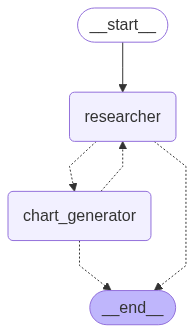

In [65]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

app

In [69]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})

TypeError: 'AIMessage' object is not subscriptable